## Language Modeling

- Language modeling is the task of predicting the next word in a sequence of words.
    - It is a type of machine learning algorithm that is used to generate text.

### Types of Language Modeling

- **Autoregressive Language Modeling**:
  - This is the most common type of language modeling.


We will start by building a **character-level** language model, which is a type of autoregressive language model.  It is given a sequence of characters, and it predicts the next character in the sequence.  In our case, we will give it sequences of characters that represent **names** with the goal of learning name patterns that will allow us to generate (or predict) new names.

We will build different types of neural network models for this task, including:
  - Bigram (one character predicts the best or most likely next character)
  - Bag of Words (one word predicts the best or most likely next word)
  - MLP (multi-layer perceptron)
  - RNN (recurrent neural network)
  - Transformer

We will use the **Character-Level Transformer Model** for our final model, as it is the most powerful and flexible model for this task.

In [2]:
words = open('makemore/names.txt').read().splitlines() # list of 32K names

In [5]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [8]:
shortest = min(len(w)for w in words)
longest = max(len(w)for w in words)

print(f"Shortest name length: {shortest}, Longest name: {longest}")

Shortest name length: 2, Longest name: 15


### Bigram Model

Bigram model just models the most likely character to follow a given character. So, its two characters in a row - hence the name "bigram".

In the case of our name dataset, there is a lot packed into each name.  For our bigram model for e.g. the name "isabella" - it tells us that a name is most likely to start with "i" and end with "a".  It also tells us that the character "i" is most likely to be followed by "s" and then a "b".  Finally, we also know that after the last "a" the word ends.

We iterate through through each word, with a sliding window of 2 characters at a time.  We then use this data to train our bigram model.

In [10]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m
m m
m a


So our code snippet above prints out bigrams for the word "emma".

We can see that the bigram "e m" appears 3 times, "m m" appears 1 time, and "a " appears 2 times.

We can use this data to train our bigram model.

But we need to take into account the beginning and end of the word.  We can do this by adding a special start and end character to the beginning and end of each word.

In [13]:
for w in words[:2]:
    chs = ['<S>'] + list(w) + ['<E>'] # we add special start and end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)


<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>


So our bigrams have expanded to include bigrames with the start and end characters.

Now we are going to count the frequency of each bigram in our dataset and record that in a dictionary.

In [15]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # we add special start and end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

Now the dictionary `b` contains the frequency of each bigram in our dataset.

In [17]:
print(b[('a', 'n')])
print(b[('e', 'm')])

5438
769


The bigram `('a', 'n')` appears 5438 times in our dataset and the bigram `('e', 'm')` appears 769 times.

We can sort the bigrams by frequency to get the most common bigrams.

In [18]:
sorted(b.items(), key=lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

It is more efficient to store the bigrams in a 2D array.  To do this we will use pytorch tensor.

We have 26 characters and 27 start and end characters, so we will need a 28 x 28 tensor to store the bigrams.

In [20]:
import torch

In [24]:
N = torch.zeros((28, 28), dtype=torch.int32)

In [26]:
# lookup table for our characters
chars = sorted(list(set(''.join(words))))
# string to integer mapping
stoi = {s: i for i, s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27

# encode the entire names dataset
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

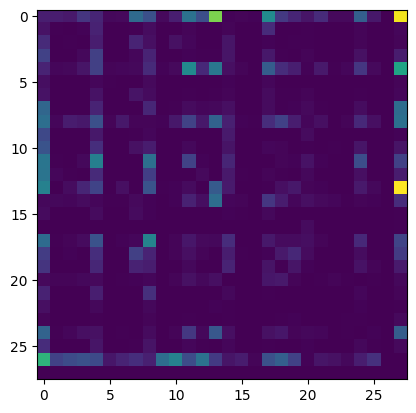

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(N) # do a heat map of the bigram 28x28 tensor

Lets do a clearer image.  The image above is nice, but still hard to visualize

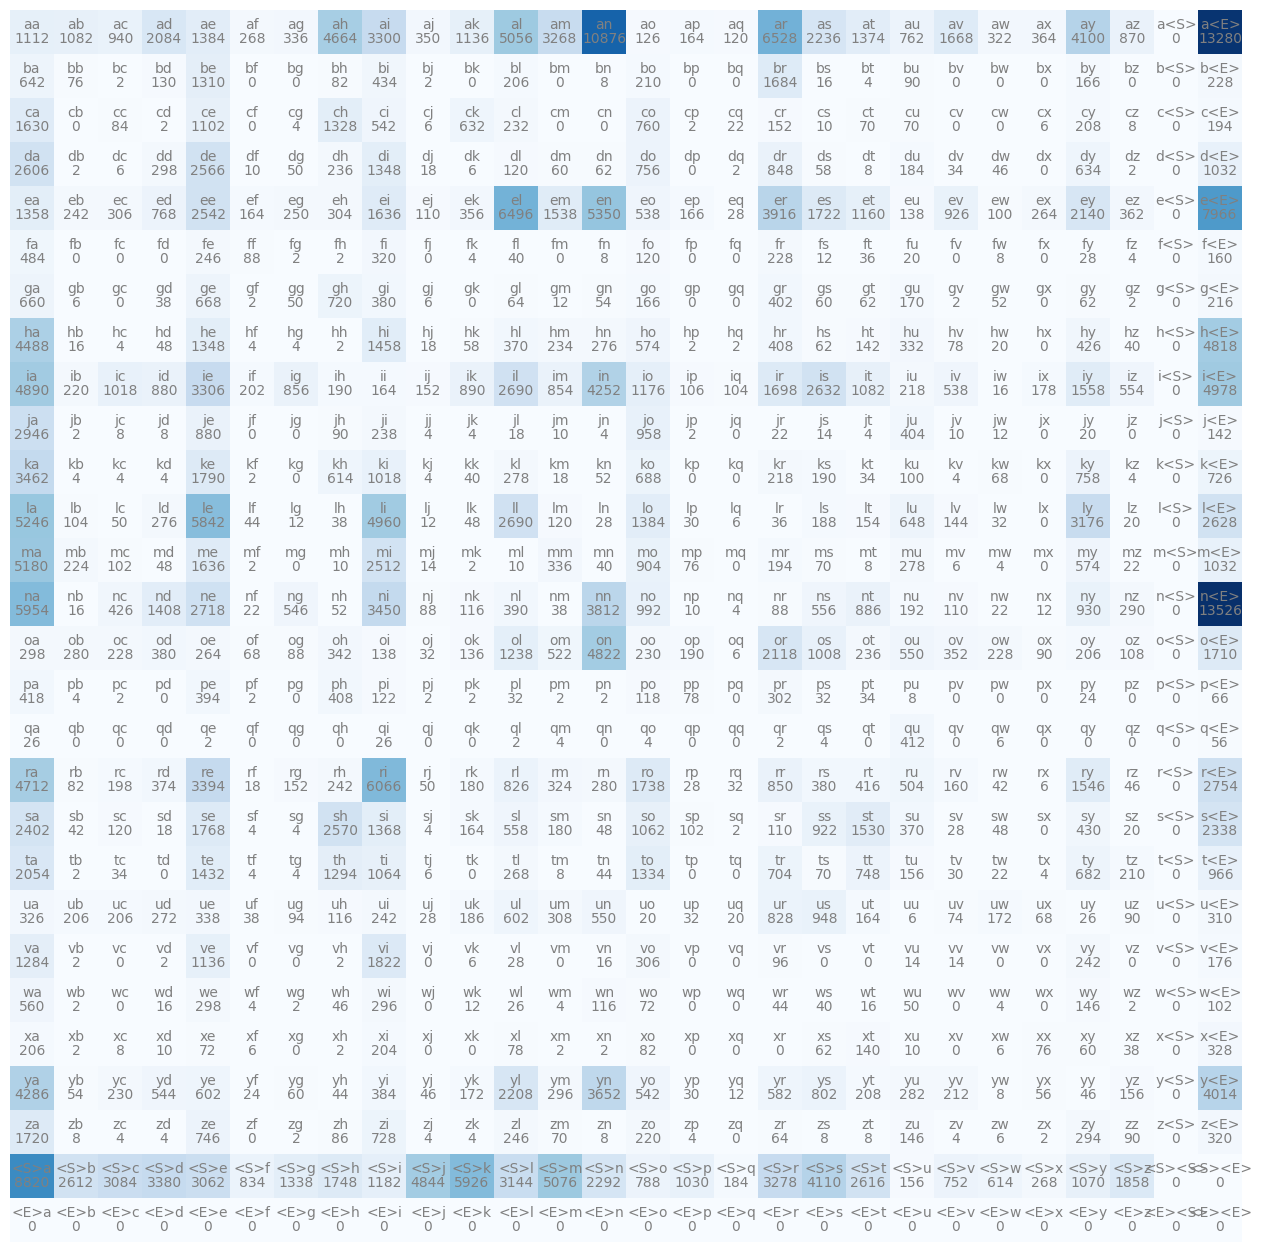

In [30]:
itos = {i: s for s, i in stoi.items()}

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off');
plt.show()

